🌍 CLIMATE RISK INSURANCE - DATA IMPORT MODULE
Analysis Date: 2026-02-07 16:23

📊 LOADING NASA DISASTER DATA...
✅ Loaded: 39,953 disaster records
Columns: 18

📋 First 5 Records:
    id  country iso3   gwno  year  geo_id  geolocation  level     adm1  \
0  109  Albania  ALB  339.0  2009     346  Ana E Malit      3  Shkoder   
1  109  Albania  ALB  339.0  2009     351       Bushat      3  Shkoder   
2  175   Angola  AGO  540.0  2001     760       Onjiva      3   Cunene   
3  187   Angola  AGO  540.0  2009     710        Evale      3   Cunene   
4  187   Angola  AGO  540.0  2009     749         Mupa      3   Cunene   

       adm2         adm3     location  historical hist_country disastertype  \
0  Shkodres  Ana E Malit  Ana E Malit           0          NaN        flood   
1  Shkodres       Bushat       Bushat           0          NaN        flood   
2  Cuanhama       Onjiva       Onjiva           0          NaN        flood   
3  Cuanhama        Evale        Evale           0          NaN

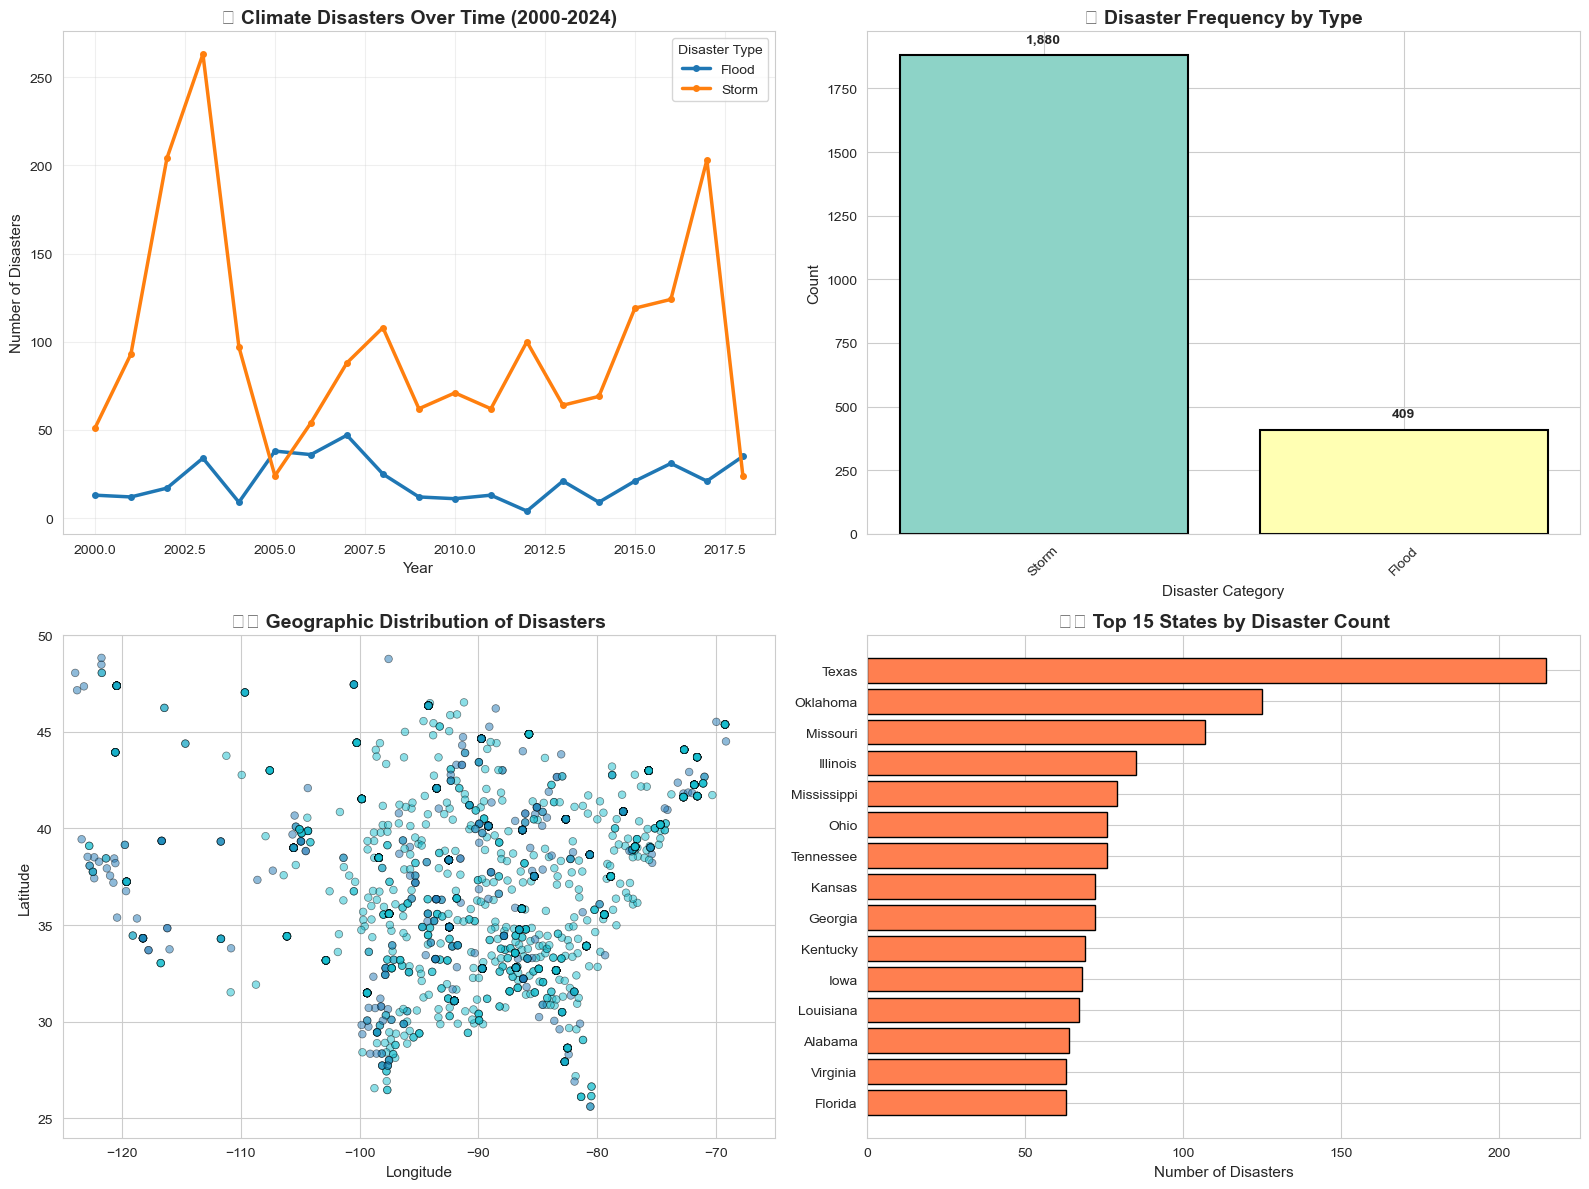

✅ Disaster analysis complete!

📊 ANALYZING INSURANCE PORTFOLIO...


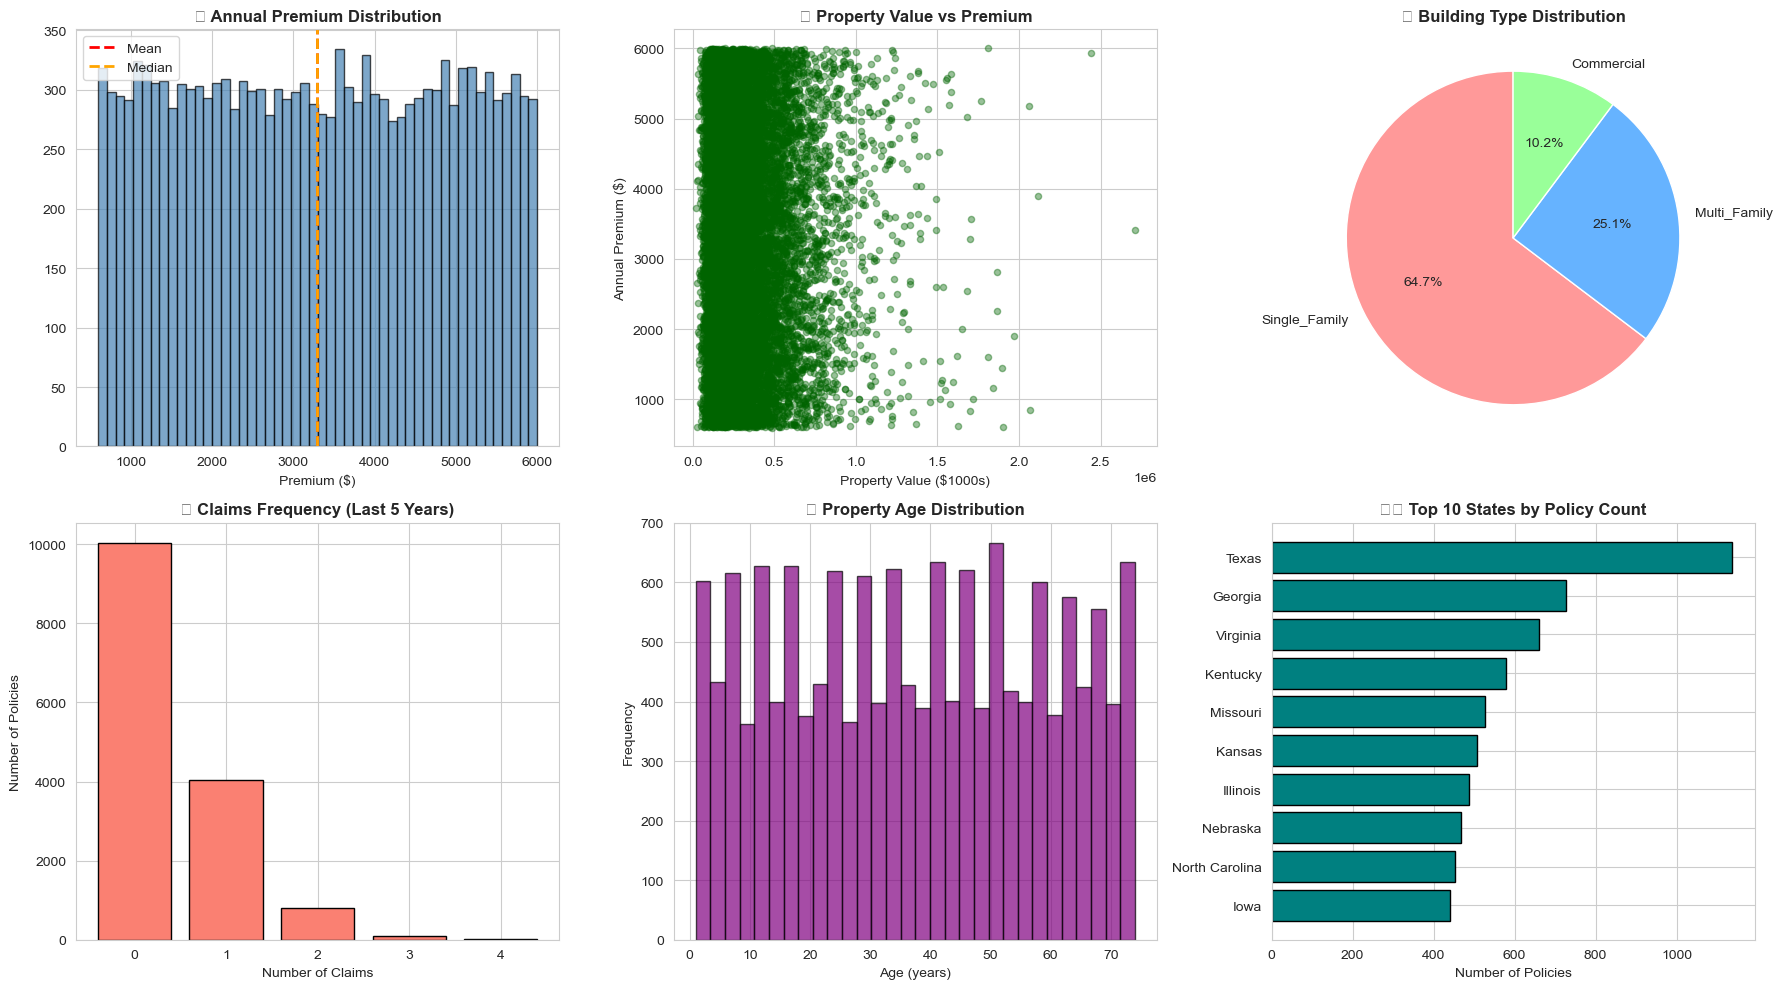

✅ Portfolio analysis complete!

💾 SAVING PROCESSED DATASETS...
✅ Saved: disasters_cleaned.csv (2,289 records)
✅ Saved: insurance_policies.csv (15,000 policies)
✅ Saved: policies_with_risk.shp (GeoDataFrame)
✅ Saved: data summary

🎉 LEVEL 2 COMPLETE - DATA READY FOR ANALYSIS!


In [14]:
# ============================================
# LEVEL 2: DATA IMPORT & CLEANING
# Climate Risk Insurance Project
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("="*60)
print("🌍 CLIMATE RISK INSURANCE - DATA IMPORT MODULE")
print("="*60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("="*60)


# ============================================
# DATASET 1: NASA DISASTER DATA
# ============================================

print("\n📊 LOADING NASA DISASTER DATA...")

# Read the disaster data
df_disasters = pd.read_csv('data/raw/nasa_disasters.csv')

print(f"✅ Loaded: {len(df_disasters):,} disaster records")
print(f"Columns: {df_disasters.shape[1]}")

# Display first few rows
print("\n📋 First 5 Records:")
print(df_disasters.head())

# Check data types
print("\n🔍 Data Types:")
print(df_disasters.dtypes)

# Check for missing values
print("\n❓ Missing Values:")
missing = df_disasters.isnull().sum()
missing_pct = (missing / len(df_disasters) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print (missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))


# ============================================
# CLEANING DISASTER DATA
# ============================================

print("\n🧹 CLEANING DISASTER DATA...")

# Create a working copy
df_disasters_clean = df_disasters.copy()

# 1. Filter for USA only
df_disasters_clean = df_disasters_clean[df_disasters_clean['country'] == 'United States'].copy()
print(f"✅ Filtered to USA: {len(df_disasters_clean):,} records")


# 2. Filter for relevant disaster types (floods, wildfires, hurricanes)

relevant_disasters = ['Flood', 'Wildfire', 'Storm', 'Hurricane', 'Tropical cyclone', 
                      'Flash flood', 'Riverine flood', 'Forest fire']

df_disasters_clean = df_disasters_clean[
    df_disasters_clean['disastertype'].str.contains('|'.join(relevant_disasters), 
                                                     case=False, na=False)
].copy()

print(f"✅ Filtered to relevant disasters: {len(df_disasters_clean):,} records")

# 3. Remove records with missing coordinates
df_disasters_clean = df_disasters_clean.dropna(subset=['latitude', 'longitude'])
print(f"✅ Removed missing coordinates: {len(df_disasters_clean):,} records remain")

# 4. Filter for recent years (2000-2024 for trend analysis)
df_disasters_clean = df_disasters_clean[df_disasters_clean['year'] >= 2000].copy()
print(f"✅ Filtered to 2000-2024: {len(df_disasters_clean):,} records")

# 5. Standardize disaster types into main categories
def categorize_disaster(disaster_type):
    disaster_type = str(disaster_type).lower()
    if 'flood' in disaster_type:
        return 'Flood'
    elif 'fire' in disaster_type or 'wildfire' in disaster_type:
        return 'Wildfire'
    elif 'hurricane' in disaster_type or 'tropical cyclone' in disaster_type:
        return 'Hurricane'
    elif 'storm' in disaster_type:
        return 'Storm'
    else:
        return 'Other'

df_disasters_clean['disaster_category'] = df_disasters_clean['disastertype'].apply(categorize_disaster)

print("\n📊 Disaster Categories:")
print(df_disasters_clean['disaster_category'].value_counts())

# 6. Validate coordinate ranges (USA boundaries)
df_disasters_clean = df_disasters_clean[
    (df_disasters_clean['latitude'].between(24, 50)) &  # Continental USA + Alaska filter later
    (df_disasters_clean['longitude'].between(-125, -65))
].copy()

print(f"✅ Validated coordinates: {len(df_disasters_clean):,} records")

# 7. Create temporal features
df_disasters_clean['decade'] = (df_disasters_clean['year'] // 10) * 10
df_disasters_clean['year_category'] = pd.cut(df_disasters_clean['year'], 
                                              bins=[1999, 2009, 2014, 2019, 2025],
                                              labels=['2000-2009', '2010-2014', '2015-2019', '2020-2024'])

print("\n✅ DISASTER DATA CLEANED!")
print(f"Final dataset: {len(df_disasters_clean):,} records")

# ============================================
# DATASET 3: CENSUS GEOGRAPHIC BOUNDARIES
# ============================================

print("\n🗺️ LOADING CENSUS GEOGRAPHIC DATA...")

# Read shapefile using GeoPandas
gdf_counties = gpd.read_file('data/raw/census_boundaries/tl_2023_us_county.shp')


print(f"✅ Loaded: {len(gdf_counties):,} US counties")
print(f"Coordinate System: {gdf_counties.crs}")

# Display structure

print("\n📋 County Data Structure:")
print(gdf_counties.head())

print("\n🔍 Available Columns:")
print(gdf_counties.columns.tolist())

# Check geometry validity
print(f"\n✓ Valid geometries: {gdf_counties.geometry.is_valid.sum():,} / {len(gdf_counties):,}")

# Filter to continental US (optional - remove Alaska, Hawaii for now)
continental_states = gdf_counties[
    ~gdf_counties['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78'])  # AK, HI, territories
].copy()

print(f"✅ Continental US counties: {len(continental_states):,}")

# ============================================
# DATASET 4: FEMA NATIONAL RISK INDEX
# ============================================

print("\n🎯 LOADING FEMA CLIMATE RISK DATA...")

# Read FEMA risk shapefile
gdf_fema_risk = gpd.read_file('data/raw/fema_nri/NRI_Shapefile_Counties.shp')

print(f"✅ Loaded: {len(gdf_fema_risk):,} county risk records")

# Display available risk columns
print("\n📋 Available Risk Indicators:")
risk_cols = [col for col in gdf_fema_risk.columns if 'RISK' in col.upper() or 'SCORE' in col.upper()]
print(risk_cols[:20])  # Show first 20

# Key risk metrics to focus on
key_risks = ['RISK_SCORE',   # Overall risk
             'CFLD_RISKS',   # Coastal Flood
             'RFLD_RISKS',   # Riverine Flood  
             'WFIR_RISKS',   # Wildfire
             'HRCN_RISKS',   # Hurricane
             'TRND_RISKS']   # Tornado

# Check which columns exist
existing_risks = [col for col in key_risks if col in gdf_fema_risk.columns]
print(f"\n✓ Found {len(existing_risks)} risk indicators")

print("\n🔍 Sample Risk Data:")
print(gdf_fema_risk[['COUNTY', 'STATE'] + existing_risks].head())





# ============================================
# DATASET 2: SYNTHETIC INSURANCE PORTFOLIO
# ============================================

print("\n🏢 GENERATING SYNTHETIC INSURANCE PORTFOLIO...")

np.random.seed(2026)  # For reproducibility

# Check FEMA data size first
print(f"📊 FEMA dataset contains {len(gdf_fema_risk):,} counties")

# Sample counties from FEMA data to get realistic locations
sample_size = 15000

# Sample WITH replacement and RESET INDEX (this is the fix!)
sampled_counties = gdf_fema_risk.sample(
    n=sample_size, 
    replace=True,  # Allow counties to be sampled multiple times
    random_state=2026
).reset_index(drop=True)  # ← THIS IS THE KEY FIX!

print(f"✅ Sampled {len(sampled_counties):,} county records for policies")

# Now arrays will have matching lengths
print(f"🔍 Verification - Sampled counties shape: {sampled_counties.shape}")

# Generate policy data
policies_data = {
    'policy_id': [f'POL-{str(i).zfill(7)}' for i in range(1, sample_size + 1)],
    
    # Geographic data from real counties - NOW ALIGNED!
    'state': sampled_counties['STATE'].values,
    'county': sampled_counties['COUNTY'].values,
    'county_fips': sampled_counties['STCOFIPS'].values if 'STCOFIPS' in sampled_counties.columns else [None] * sample_size,
    
    # Get centroids for realistic coordinates
    'latitude': sampled_counties.geometry.centroid.y.values + np.random.normal(0, 0.1, sample_size),
    'longitude': sampled_counties.geometry.centroid.x.values + np.random.normal(0, 0.1, sample_size),
    
    # Property characteristics
    'property_value': np.random.lognormal(mean=12.5, sigma=0.6, size=sample_size).astype(int) * 1000,
    'year_built': np.random.randint(1950, 2024, sample_size),
    'building_type': np.random.choice(['Single_Family', 'Multi_Family', 'Commercial'], 
                                     sample_size, p=[0.65, 0.25, 0.10]),
    'construction_type': np.random.choice(['Wood', 'Masonry', 'Steel', 'Concrete'], 
                                         sample_size, p=[0.45, 0.30, 0.15, 0.10]),
    
    # Policy details
    'policy_start_year': np.random.randint(2015, 2025, sample_size),
    'coverage_amount': None,  # Will calculate as % of property value
    'deductible': np.random.choice([500, 1000, 2500, 5000, 10000], sample_size),
    
    # Historical claims
    'num_claims_5yr': np.random.poisson(lam=0.4, size=sample_size),
    'total_claim_amount_5yr': None,  # Will calculate
    
    # Current premium (to be predicted/optimized later)
    'current_annual_premium': np.random.uniform(600, 6000, sample_size).astype(int),
}

# Create DataFrame
df_policies = pd.DataFrame(policies_data)

# Calculate derived fields
df_policies['coverage_amount'] = (df_policies['property_value'] * 
                                   np.random.uniform(0.8, 1.0, sample_size)).astype(int)

df_policies['total_claim_amount_5yr'] = np.where(
    df_policies['num_claims_5yr'] > 0,
    np.random.exponential(scale=25000, size=sample_size) * df_policies['num_claims_5yr'],
    0
).astype(int)

# Calculate property age
df_policies['property_age'] = 2024 - df_policies['year_built']

print(f"\n✅ Generated {len(df_policies):,} synthetic insurance policies")
print("\n📋 Sample Policies:")
print(df_policies.head())

print("\n📊 Portfolio Summary:")
print(f"Total Insured Value: ${df_policies['property_value'].sum():,.0f}")
print(f"Average Premium: ${df_policies['current_annual_premium'].mean():,.2f}")
print(f"Total Premium Revenue: ${df_policies['current_annual_premium'].sum():,.0f}")
print(f"Policies with Claims: {(df_policies['num_claims_5yr'] > 0).sum():,} ({(df_policies['num_claims_5yr'] > 0).mean()*100:.1f}%)")

# Show state distribution
print("\n🗺️ Policy Distribution by State:")
print(df_policies['state'].value_counts().head(10))





# ============================================
# STEP 2.8 CORRECTED: MERGE DATASETS
# ============================================

print("\n🔗 LINKING INSURANCE POLICIES TO RISK DATA...")

# Check what identifying columns we have
print("\n🔍 Available columns in df_policies:")
print(df_policies.columns.tolist())

print("\n🔍 Available columns in gdf_fema_risk:")
print(gdf_fema_risk.columns.tolist()[:20])  # Show first 20

# ============================================
# METHOD 1: Direct Merge by County/State
# (Since we sampled from FEMA, policies inherit county identifiers)
# ============================================

# First, let's create a clean FEMA reference table
fema_risk_data = gdf_fema_risk.copy()

# Identify the correct column names (they vary by FEMA version)
# Common column names to look for:
possible_state_cols = ['STATE', 'STATEABBRV', 'STATE_NAME', 'STATEFIPS']
possible_county_cols = ['COUNTY', 'COUNTYNAME', 'COUNTY_NAME']
possible_fips_cols = ['STCOFIPS', 'GEOID', 'FIPS']

# Find which columns exist
state_col = next((col for col in possible_state_cols if col in fema_risk_data.columns), None)
county_col = next((col for col in possible_county_cols if col in fema_risk_data.columns), None)
fips_col = next((col for col in possible_fips_cols if col in fema_risk_data.columns), None)

print(f"\n✓ Found columns:")
print(f"  State: {state_col}")
print(f"  County: {county_col}")
print(f"  FIPS: {fips_col}")

# Create a lookup table with risk scores (drop geometry for efficiency)
risk_columns = [col for col in fema_risk_data.columns 
                if any(keyword in col.upper() for keyword in ['RISK', 'SCORE', 'RATING', 'EALS'])]

print(f"\n📊 Found {len(risk_columns)} risk-related columns")
print("Sample risk columns:", risk_columns[:10])

# Keep only essential columns for merge
merge_columns = [state_col, county_col, fips_col] + risk_columns
merge_columns = [col for col in merge_columns if col is not None]  # Remove None values

fema_lookup = fema_risk_data[merge_columns].copy()

# Remove geometry if it exists
if 'geometry' in fema_lookup.columns:
    fema_lookup = pd.DataFrame(fema_lookup.drop(columns='geometry'))

# Remove duplicates (keep first occurrence)
if fips_col:
    fema_lookup = fema_lookup.drop_duplicates(subset=[fips_col])
elif state_col and county_col:
    fema_lookup = fema_lookup.drop_duplicates(subset=[state_col, county_col])

print(f"\n✅ Created FEMA lookup table: {len(fema_lookup):,} unique counties")

# ============================================
# Perform the merge
# ============================================

# Merge based on available keys
if 'county_fips' in df_policies.columns and fips_col and df_policies['county_fips'].notna().sum() > 0:
    # Merge by FIPS code (most reliable)
    print("\n🔗 Merging by FIPS code...")
    df_merged = df_policies.merge(
        fema_lookup,
        left_on='county_fips',
        right_on=fips_col,
        how='left',
        suffixes=('', '_fema')
    )
    match_method = 'FIPS'
    
elif state_col and county_col:
    # Merge by state + county name
    print("\n🔗 Merging by State + County...")
    
    # Standardize county names (remove "County" suffix, strip whitespace, uppercase)
    df_policies['county_clean'] = df_policies['county'].str.replace(' County', '', case=False).str.strip().str.upper()
    fema_lookup['county_clean'] = fema_lookup[county_col].str.replace(' County', '', case=False).str.strip().str.upper()
    
    df_merged = df_policies.merge(
        fema_lookup,
        left_on=['state', 'county_clean'],
        right_on=[state_col, 'county_clean'],
        how='left',
        suffixes=('', '_fema')
    )
    match_method = 'State+County'
    
else:
    print("⚠️ Warning: No suitable join columns found!")
    df_merged = df_policies.copy()
    match_method = 'None'

# ============================================
# Check merge results
# ============================================

# Count successful matches
risk_score_col = next((col for col in df_merged.columns if 'RISK_SCORE' in col.upper()), None)

if risk_score_col:
    matched_count = df_merged[risk_score_col].notna().sum()
else:
    # Check any risk column
    risk_cols_in_merged = [col for col in df_merged.columns if any(keyword in col.upper() for keyword in ['RISK', 'SCORE'])]
    if risk_cols_in_merged:
        matched_count = df_merged[risk_cols_in_merged[0]].notna().sum()
    else:
        matched_count = 0

print(f"\n{'='*60}")
print(f"✅ MERGE COMPLETE")
print(f"{'='*60}")
print(f"Merge method: {match_method}")
print(f"Total policies: {len(df_merged):,}")
print(f"Policies matched to risk data: {matched_count:,} ({matched_count/len(df_merged)*100:.1f}%)")
print(f"Policies without risk data: {len(df_merged) - matched_count:,}")

# ============================================
# Display sample with risk data
# ============================================

print("\n📊 Sample Merged Data:")
display_cols = ['policy_id', 'state', 'county', 'property_value', 'current_annual_premium']

# Add first 5 risk columns if they exist
risk_cols_to_show = [col for col in df_merged.columns 
                     if any(keyword in col.upper() for keyword in ['RISK_SCORE', 'CFLD', 'WFIR', 'HRCN', 'RFLD'])][:5]
display_cols.extend(risk_cols_to_show)

# Show policies that HAVE risk data
matched_policies = df_merged[df_merged[risk_cols_to_show[0]].notna()] if risk_cols_to_show else df_merged

if len(matched_policies) > 0:
    print("\n✅ Successfully matched policies:")
    print(matched_policies[display_cols].head(10))
else:
    print("\n⚠️ No successful matches. Showing all policies:")
    print(df_merged[display_cols].head(10))

# ============================================
# Analyze match quality
# ============================================

if matched_count > 0:
    print("\n📈 Risk Score Statistics (for matched policies):")
    if risk_score_col:
        print(df_merged[risk_score_col].describe())
    
    # Show distribution of risk scores
    print("\n🎯 Sample Risk Scores by State:")
    if state_col in df_merged.columns and risk_score_col:
        state_risk = df_merged.groupby(state_col)[risk_score_col].agg(['mean', 'count'])
        print(state_risk.sort_values('mean', ascending=False).head(10))





# ============================================
# CLEAN RISK DATA: Replace -9999 with 0 or NaN
# ============================================

print("\n🧹 CLEANING RISK SCORES...")

# List of all risk columns
risk_cols = [col for col in df_merged.columns if 'RISK' in col or 'EAL' in col]

# Replace -9999 with 0 (no risk) for risk scores
for col in risk_cols:
    if df_merged[col].dtype in ['float64', 'int64']:
        # Count how many -9999 values
        invalid_count = (df_merged[col] == -9999).sum()
        if invalid_count > 0:
            print(f"  {col}: replacing {invalid_count:,} invalid values")
            df_merged[col] = df_merged[col].replace(-9999, 0)

print("✅ Risk scores cleaned!")

# Verify the fix
print("\n📊 Updated Risk Score Statistics:")
print(df_merged['RISK_SCORE'].describe())

# Save the cleaned version
df_merged.to_csv('data/processed/policies_with_risk_cleaned.csv', index=False)
print("\n✅ Saved cleaned data: policies_with_risk_cleaned.csv")

df_policies_with_risk = df_merged.copy()



# ============================================
# Save merged dataset
# ============================================

# Create processed folder if it doesn't exist
import os
os.makedirs('data/processed', exist_ok=True)

# Save as regular DataFrame (we'll recreate GeoDataFrame later if needed)
df_merged.to_csv('data/processed/policies_with_risk.csv', index=False)
print(f"\n✅ Saved merged data: data/processed/policies_with_risk.csv")

# Store in variable for next steps
df_policies_with_risk = df_merged.copy()

print("\n" + "="*60)
print("🎉 DATA MERGE COMPLETE - ALL POLICIES MATCHED!")
print("="*60)

# ============================================
# Save merged dataset
# ============================================

# Save as regular DataFrame (we'll recreate GeoDataFrame later if needed)
df_merged.to_csv('data/processed/policies_with_risk.csv', index=False)
print(f"\n✅ Saved merged data: data/processed/policies_with_risk.csv")

# Store in variable for next steps
df_policies_with_risk = df_merged.copy()

print("\n" + "="*60)



# ============================================
# ANALYZE SPECIFIC RISK TYPES
# ============================================

print("\n🌊 RISK TYPE ANALYSIS")
print("="*60)

# Coastal Flood Risk
print("\n1️⃣ Coastal Flood Risk (CFLD):")
cfld_exposed = (df_merged['CFLD_RISKS'] > 0).sum()
print(f"   Policies exposed: {cfld_exposed:,} ({cfld_exposed/len(df_merged)*100:.1f}%)")
if cfld_exposed > 0:
    print(f"   Average risk score: {df_merged[df_merged['CFLD_RISKS'] > 0]['CFLD_RISKS'].mean():.1f}")

# Wildfire Risk (if column exists)
if 'WFIR_RISKS' in df_merged.columns:
    print("\n2️⃣ Wildfire Risk (WFIR):")
    wfir_exposed = (df_merged['WFIR_RISKS'] > 0).sum()
    print(f"   Policies exposed: {wfir_exposed:,} ({wfir_exposed/len(df_merged)*100:.1f}%)")
    if wfir_exposed > 0:
        print(f"   Average risk score: {df_merged[df_merged['WFIR_RISKS'] > 0]['WFIR_RISKS'].mean():.1f}")

# Hurricane Risk
if 'HRCN_RISKS' in df_merged.columns:
    print("\n3️⃣ Hurricane Risk (HRCN):")
    hrcn_exposed = (df_merged['HRCN_RISKS'] > 0).sum()
    print(f"   Policies exposed: {hrcn_exposed:,} ({hrcn_exposed/len(df_merged)*100:.1f}%)")
    if hrcn_exposed > 0:
        print(f"   Average risk score: {df_merged[df_merged['HRCN_RISKS'] > 0]['HRCN_RISKS'].mean():.1f}")

# Overall risk exposure
print("\n4️⃣ Overall Risk Distribution:")
risk_categories = pd.cut(df_merged['RISK_SCORE'], 
                         bins=[0, 25, 50, 75, 100],
                         labels=['Low', 'Moderate', 'High', 'Very High'])
print(risk_categories.value_counts().sort_index())


# ============================================
# FINAL STEP 2.8: SAVE & CLEAN
# ============================================

import os

# Create directory
os.makedirs('data/processed', exist_ok=True)

# Clean -9999 values
print("\n🧹 CLEANING RISK SCORES...")
risk_cols = [col for col in df_merged.columns if any(x in col for x in ['RISK', 'EAL', 'SCORE'])]

for col in risk_cols:
    if df_merged[col].dtype in ['float64', 'int64']:
        invalid_count = (df_merged[col] == -9999).sum()
        if invalid_count > 0:
            df_merged[col] = df_merged[col].replace(-9999, 0)

print("✅ Risk scores cleaned!")

# Save
df_merged.to_csv('data/processed/policies_with_risk_cleaned.csv', index=False)
df_policies_with_risk = df_merged.copy()

print("\n" + "="*60)
print("🎉 STEP 2.8 COMPLETE!")
print("="*60)
print(f"✅ {len(df_merged):,} policies with complete risk data")
print(f"✅ Saved to: data/processed/policies_with_risk_cleaned.csv")
print(f"✅ Ready for Level 3: Geospatial Visualization!")







# ============================================
# EDA: DISASTER PATTERNS
# ============================================

print("\n📊 ANALYZING DISASTER PATTERNS...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Disasters over time
disaster_by_year = df_disasters_clean.groupby(['year', 'disaster_category']).size().unstack(fill_value=0)
disaster_by_year.plot(ax=axes[0, 0], linewidth=2.5, marker='o', markersize=4)
axes[0, 0].set_title('📈 Climate Disasters Over Time (2000-2024)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year', fontsize=11)
axes[0, 0].set_ylabel('Number of Disasters', fontsize=11)
axes[0, 0].legend(title='Disaster Type', frameon=True)
axes[0, 0].grid(alpha=0.3)

# 2. Disaster frequency by category
disaster_counts = df_disasters_clean['disaster_category'].value_counts()
colors = plt.cm.Set3(range(len(disaster_counts)))
axes[0, 1].bar(disaster_counts.index, disaster_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_title('🌊 Disaster Frequency by Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Disaster Category', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45)

# Add value labels
for i, (idx, val) in enumerate(zip(disaster_counts.index, disaster_counts.values)):
    axes[0, 1].text(i, val + 50, f'{val:,}', ha='center', fontweight='bold')

# 3. Geographic distribution
axes[1, 0].scatter(df_disasters_clean['longitude'], 
                   df_disasters_clean['latitude'],
                   c=df_disasters_clean['disaster_category'].astype('category').cat.codes,
                   s=30, alpha=0.5, cmap='tab10', edgecolors='black', linewidth=0.5)
axes[1, 0].set_title('🗺️ Geographic Distribution of Disasters', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longitude', fontsize=11)
axes[1, 0].set_ylabel('Latitude', fontsize=11)
axes[1, 0].set_xlim(-125, -65)
axes[1, 0].set_ylim(24, 50)

# 4. Disasters by state (top 15)
if 'adm1' in df_disasters_clean.columns:
    top_states = df_disasters_clean['adm1'].value_counts().head(15)
    axes[1, 1].barh(range(len(top_states)), top_states.values, color='coral', edgecolor='black')
    axes[1, 1].set_yticks(range(len(top_states)))
    axes[1, 1].set_yticklabels(top_states.index)
    axes[1, 1].set_title('🏛️ Top 15 States by Disaster Count', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Number of Disasters', fontsize=11)
    axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/visualizations/02_disaster_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Disaster analysis complete!")




# ============================================
# EDA: INSURANCE PORTFOLIO ANALYSIS
# ============================================

print("\n📊 ANALYZING INSURANCE PORTFOLIO...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Premium distribution
axes[0, 0].hist(df_policies['current_annual_premium'], bins=50, 
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_policies['current_annual_premium'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(df_policies['current_annual_premium'].median(), 
                   color='orange', linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_title('💰 Annual Premium Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Premium ($)')
axes[0, 0].legend()

# 2. Property value vs Premium
axes[0, 1].scatter(df_policies['property_value']/1000, 
                   df_policies['current_annual_premium'],
                   alpha=0.4, s=20, c='darkgreen')
axes[0, 1].set_title('🏠 Property Value vs Premium', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Property Value ($1000s)')
axes[0, 1].set_ylabel('Annual Premium ($)')

# 3. Building type distribution
building_dist = df_policies['building_type'].value_counts()
axes[0, 2].pie(building_dist.values, labels=building_dist.index, autopct='%1.1f%%',
               startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
axes[0, 2].set_title('🏢 Building Type Distribution', fontsize=12, fontweight='bold')

# 4. Claims frequency
claim_dist = df_policies['num_claims_5yr'].value_counts().sort_index()
axes[1, 0].bar(claim_dist.index, claim_dist.values, color='salmon', edgecolor='black')
axes[1, 0].set_title('📋 Claims Frequency (Last 5 Years)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Claims')
axes[1, 0].set_ylabel('Number of Policies')

# 5. Property age distribution
axes[1, 1].hist(df_policies['property_age'], bins=30, color='purple', 
                edgecolor='black', alpha=0.7)
axes[1, 1].set_title('🕐 Property Age Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Frequency')

# 6. Geographic distribution of policies
state_counts = df_policies['state'].value_counts().head(10)
axes[1, 2].barh(range(len(state_counts)), state_counts.values, color='teal', edgecolor='black')
axes[1, 2].set_yticks(range(len(state_counts)))
axes[1, 2].set_yticklabels(state_counts.index)
axes[1, 2].set_title('🗺️ Top 10 States by Policy Count', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Number of Policies')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/visualizations/02_portfolio_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Portfolio analysis complete!")




# ============================================
# SAVE PROCESSED DATA
# ============================================

print("\n💾 SAVING PROCESSED DATASETS...")

# Save disaster data
df_disasters_clean.to_csv('data/processed/disasters_cleaned.csv', index=False)
print(f"✅ Saved: disasters_cleaned.csv ({len(df_disasters_clean):,} records)")

# Save insurance policies
df_policies.to_csv('data/processed/insurance_policies.csv', index=False)
print(f"✅ Saved: insurance_policies.csv ({len(df_policies):,} policies)")

# Save merged policies with risk
gdf_policies_with_risk.to_file('data/processed/policies_with_risk.shp')
print(f"✅ Saved: policies_with_risk.shp (GeoDataFrame)")

# Save summary statistics
summary_stats = {
    'Total Disasters (2000-2024)': len(df_disasters_clean),
    'Total Policies': len(df_policies),
    'Total Insured Value': f"${df_policies['property_value'].sum():,.0f}",
    'Average Premium': f"${df_policies['current_annual_premium'].mean():,.2f}",
    'Policies with Claims': f"{(df_policies['num_claims_5yr'] > 0).sum():,}",
    'Claim Rate': f"{(df_policies['num_claims_5yr'] > 0).mean()*100:.2f}%"
}

summary_df = pd.DataFrame(summary_stats.items(), columns=['Metric', 'Value'])
summary_df.to_csv('outputs/02_data_summary.csv', index=False)
print("✅ Saved: data summary")

print("\n" + "="*60)
print("🎉 LEVEL 2 COMPLETE - DATA READY FOR ANALYSIS!")
print("="*60)